<a href="https://colab.research.google.com/github/gvarnavi/generative-art-iap/blob/master/01.16-Thursday/03X_reaction-diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gray-Scott Model of Reaction Diffusion

The Gray-Scott model of a reaction diffusion system with two interacting species $U$ and $V$ is given by:
$$
\begin{align}
\frac{\partial{u}}{\partial{t}} &= D_u\nabla^2u - uv^2 + f(1-u) \\
\frac{\partial{v}}{\partial{t}} &= D_v\nabla^2v + uv^2 - (f+k)v
\end{align}
$$

where $u$ and $v$ represent the concentrations of the two species $U$ and $V$, respectively, $D_u$ and $D_v$ their respective diffusion constants, and $f$ and $k$ the feed rate and kill rate, respectively. For varied choices of parameters, this model is capable of producing very diverse patterns which mimic natural prints such as spots and stripes.

At the microscopic level, two chemical reactions govern the system above, at varied rates depending on the choice of model parameters:

$$
\begin{align}
U + 2V &\rightarrow 3V \\
V &\rightarrow P
\end{align}
$$

where $P$ represents an inert product which depletes the amount of $U$ and $V$ present. Our goal will be to explore the variety of interesting visual patterns this simple yet rich interacting system can exhibit.

We'll start by importing our necessary libraries:

In [0]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

Next, we define a set of helper functions for plotting and animation.

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML

# define a custom plotting function.
def plot_pattern(u, colormap='twilight'):
    '''Plot the concentration as a color image.
    u - grid of concentrations of one species.
    '''
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    im = ax.imshow(u, cmap=plt.get_cmap(colormap),
                   vmin = 0.3, vmax = 1,
                   interpolation='bicubic',
                   extent=[-1, 1, -1, 1], alpha=0.8)
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)
    ax.axis('off')
    ax.grid(False)
    
    # return handles to figure, axis, and image
    return fig, ax, im

# define a custom plotting function.
def tile_pattern(N, sol, colormap='twilight'):
    '''
    Tile 6 snapshots of a simulation into one figure.
    N - the size of the system in each dimension.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    fig, axes = plt.subplots(2,3,figsize=(12,8))
    step = sol.y.shape[1]//6
    for i, ax in enumerate(axes.flat):
        u = sol.y[:N*N,i*step].reshape(N,N)
        im = ax.imshow(u, cmap=plt.get_cmap(colormap),
                       vmin = 0.3, vmax = 1,
                       interpolation='bicubic',
                       extent=[-1, 1, -1, 1], alpha=0.8)
        ax.tick_params(labelsize=14)
        ax.set_xlim(-1,1); ax.set_ylim(-1,1)
        ax.axis('off')
        ax.grid(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

# generate a sequence of plots assembled into an animation.
def animate_pattern(N, sol, colormap='twilight'):
    '''
    Animate the Gray-Scott system.
    N - the size of the system in each dimension.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    frames = sol.y.shape[1]
    u, v = sol.y[:N*N,0].reshape(N,N), sol.y[N*N:,0].reshape(N,N)
    fig, ax, im = plot_pattern(u, colormap)

    def animate(i):
        '''Plot updates for animation.'''
        u, v = sol.y[:N*N,i].reshape(N,N), sol.y[N*N:,i].reshape(N,N)
        im.set_array(u)
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

The initialization of our system requires preparing two $N\times N$ grids: one for the concentration $u$ of the first species, and the other the concentration $v$ of the second species. We will use a built-in function ```binary_blobs``` which generates a binary image of random, blob-like structures. Where our image is 1, we will initialize $u$ to $0.5$, and to $1$ otherwise. Where our image is 1, we will initialize $v$ to $0.25$, and to $0$ otherwise.

In [0]:
from skimage.data import binary_blobs # randomly initialize a blob-like pattern

def initialize(N, seed=0):
    '''By default, initialize values of two-component system randomly.'''
    np.random.seed(seed)
    blobs = binary_blobs(N, blob_size_fraction=0.1, volume_fraction=0.3, seed=seed)
    u = np.ones((N,N)); u[blobs] = 0.5
    v = np.zeros((N,N)); v[blobs] = 0.25
    return u, v

Let's plot an example initialization.

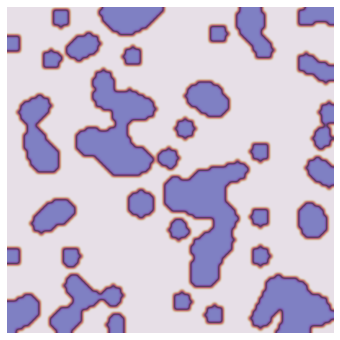

In [4]:
# initialize
N = 100
u, v = initialize(N, seed=12)

# plot the u-component
fig, ax, im = plot_pattern(u)
plt.show()

We'll be using convolution to perform a sum corresponding to the discretization of the Laplacian operator $\nabla^2$. Our convolution kernel is given by

$$
\begin{bmatrix}
0.05 & 0.2 & 0.05 \\
0.2 & -1 & 0.2 \\
0.05 & 0.2 & 0.05
\end{bmatrix}
$$

which weights nearest and next-nearest neighbors differently. You'll notice that the sum over all values of the Laplacian discretization is zero. This enforces mass conservation; since the Laplacian of the concentration is proportional to the rate of inflow or outflow from any point in space, the outflow from any given point must equal the sum of inflow contributions that point makes to any of its neighbors. 

Since we'll need two perform two Laplacian operations at each integration step, one for each species concentration, we will write a general function for the Laplacian operator that can be repurposed several times.

In [0]:
from scipy.signal import convolve2d

# use convolution to compute the Laplacian.
def laplacian2D(u, N):
    '''Compute the Laplacian of concentration.
    u - a *linear* array of concentrations (linear for compatibility with solver).
    N - the system size in each dimension (2D).
    '''
    kernel = np.array([[0.05,0.2,0.05],
                       [0.2,-1,0.2],
                       [0.05,0.2,0.05]])

    lap = convolve2d(u.reshape((N,N)), kernel,
                     mode = 'same',
                     boundary = 'wrap') # periodic boundaries
    return lap.ravel()

Our original set of equations is a system of PDEs, but by discretizing the spatial dimensions with an $N\times N$ grid, we convert our system to a set of ODEs, with time the remaining continuous integration variable. Below, we implement the ODE system in the function ```gray_scott```, in preparation to integrate using ```solve_ivp```. Then, ```gray_scott``` may be passed into the ```solve``` function which packages together the integration routine, taking in as additional arguments the initial and final integration times, the number of equally-spaced outputs, initial conditions, and constant model parameters.

In [0]:
def gray_scott(t, q, N, Du, Dv, f, k):
    '''Spatially discretized PDE for the Gray-Scott reaction-diffusion system.
        t - the current time.
        q - a *linear* array of concentrations u and v.
        N - the system size in each dimension.
        Du, Dv - the diffusion constants.
        f - the feed rate.
        k - the kill rate.
    '''
    u, v = q[:N*N], q[N*N:] # unpack the species concentrations
    dq = np.zeros(2*N*N)
    
    # compute the Laplacians.
    Lu = laplacian2D(u, N)
    Lv = laplacian2D(v, N)

    du = Du*Lu - u*v*v + f*(1 - u)
    dv = Dv*Lv + u*v*v - (f + k)*v
    
    dq[:N*N], dq[N*N:] = du, dv
    return dq

def solve(fun, ti, tf, nt, qi, args, rtol=1e-6, atol=1e-6):
    '''
    fun - the function to integrate
    ti, tf - starting and ending integration times.
    nt - number of equally spaced output points on [ti, tf].
    qi - initial conditions [u, v].
    args - tuple of model parameters (Du, Dv, a, b, c).
    rtol, atol - tolerance for tuning the accuracy of the solver.
    '''
    u, v = qi                           # unpack initial components
    N = len(u)                          # extract grid dimension
    t_span = [ti, tf]                   # integration range
    t_eval = np.linspace(ti, tf, nt)    # evaluation points
    Du, Dv, f, k = args                 # unpack extra arguments
    
    # integrate the differential equation using finite differences
    
    sol = solve_ivp(lambda t, y: fun(t,y,N,Du,Dv,f,k), t_span, np.hstack([u.ravel(), v.ravel()]),
                    t_eval=t_eval, rtol=rtol, atol=atol, method='RK23')
    return sol

With our integration routine set up, let's explore some of the varied patterns of the Gray-Scott system using an interactive widget. You will find a slider for the ratio of diffusion constants $D_u/D_v$, preset combinations for the feed and kill rates, as well as a few colormap options, to experiment with.

In [7]:
import ipywidgets as widgets
from IPython.display import display

diffusion_slider = widgets.FloatSlider(
    value=3, min=2, max=5, step=0.5,
    description='Du/Dv:', readout_format='.1f',)

@widgets.interact_manual(d=diffusion_slider,
                         presets = ['1. f=0.06, k=0.063',
                              '2. f=0.02, k=0.048',
                              '3. f=0.041, k=0.057',
                              '4. f=0.02, k=0.057'],
                         colormap = ['twilight','Spectral_r','plasma_r'])
def interactive_menu_plot(d=3, presets='1. f=0.06, k=0.063', colormap='twilight'):
    plt.close()
                             # descriptions for Du/Dv = 3:
    params = [[0.06, 0.063], # blocky maze
              [0.02, 0.048], # rounded maze
              [0.041, 0.057],# bubbles
              [0.02, 0.057]] # cell division
    f, k = params[eval(presets[0])-1]
    Du = 0.3; Dv = Du/d; N = 100
    u, v = initialize(N, seed=12)
    frames = 6
    sol = solve(gray_scott, 0, 1000, frames, [u, v], args = (Du, Dv, f, k))
    tile_pattern(N, sol, colormap)
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='Du/Dv:', max=5.0, min=2.0, readout_format='.1f', ste…

To more flexibly vary the model parameters, the widget below provides sliders for the feed and kill rates. You can use the above presets as starting points for finding your own patterns!

In [8]:
feed_slider = widgets.FloatSlider(
    value=0.06, min=0.005, max=0.1, step=0.001,
    description='Feed rate:', readout_format='.3f',)
kill_slider = widgets.FloatSlider(
    value=0.065, min=0.015, max=0.065, step=0.001,
    description='Kill rate:', readout_format='.3f',)

@widgets.interact_manual(
    d=diffusion_slider, f=feed_slider, k=kill_slider, colormap = ['twilight','Spectral_r','plasma_r'])
def interactive_slider_plot(d=3, f=0.06, k=0.063, colormap='twilight'):
    plt.close()
    Du = 0.3; Dv = Du/d; N = 100
    u, v = initialize(N, seed=12)
    frames = 6
    sol = solve(gray_scott, 0, 1000, frames, [u, v], args = (Du, Dv, f, k))
    tile_pattern(N, sol, colormap)
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='Du/Dv:', max=5.0, min=2.0, readout_format='.1f', ste…

As a final option, you can manually set the model parameters below to produce a movie of the system dynamics over time. We've also increased the system size and integration time to produce a more resolved image, so this could take up to 2 min. (Feel free to reduce these for shorter runs).

In [9]:
# *** edit the following section ***
# adjust Du/Dv ratio, feed and kill rates
d = 2
f = 0.034
k = 0.057

# system size
N = 300

# final integration time
tf = 2000

# colormap
colormap = 'twilight'
# *** end of edit section ***

# fixed model parameters
Du = 0.3; Dv = Du/d

# initialize
u, v = initialize(N, seed=12)

# integrate
frames = max(2,tf//5)
sol = solve(gray_scott, 0, tf, frames, [u, v], args = (Du, Dv, f, k))

# create animation
ani = animate_pattern(N, sol, colormap)

# Display the animation
HTML(ani.to_html5_video())